In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

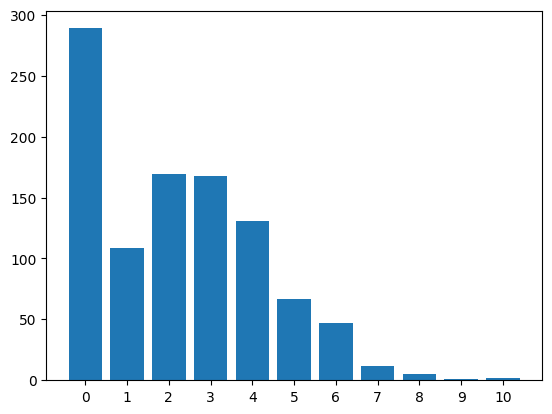

In [2]:
rng = np.random.default_rng(1234)
x = np.concatenate([np.zeros(250), rng.poisson(lam=3, size=750)])
df = pd.DataFrame({"response": x})
values, counts = np.unique(x, return_counts=True)
fig, ax = plt.subplots()
ax.bar(values, counts);
ax.set(xticks=values);

In [7]:
from bambi.families.univariate import UnivariateFamily
from bambi.families import Family

# class ZeroInflatedPoissonFamily(UnivariateFamily):
#     SUPPORTED_LINKS = {"mu": ["identity", "log"], "psi": ["logit", "probit", "cloglog"]}

likelihood = bmb.Likelihood("ZeroInflatedPoisson", params=["mu", "psi"], parent="mu")
links = {"mu": "log", "psi": "logit"}
family = Family("zero-inflated-poisson", likelihood, links)
priors = {"psi": bmb.Prior("Beta", alpha=3, beta=3)}

model = bmb.Model("response ~ 1", df, family=family, priors=priors)
model

       Formula: response ~ 1
        Family: zero-inflated-poisson
          Link: mu = log
  Observations: 1000
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.5)
        
        Auxiliary parameters
            response_psi ~ Beta(alpha: 3.0, beta: 3.0)

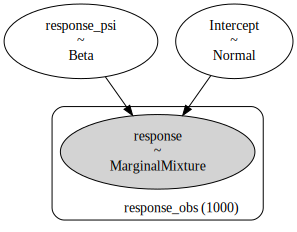

In [8]:
model.build()
model.graph()

In [ ]:
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [response_psi, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


In [ ]:
model.predict(idata, kind="pps")

<AxesSubplot: xlabel='response / response'>

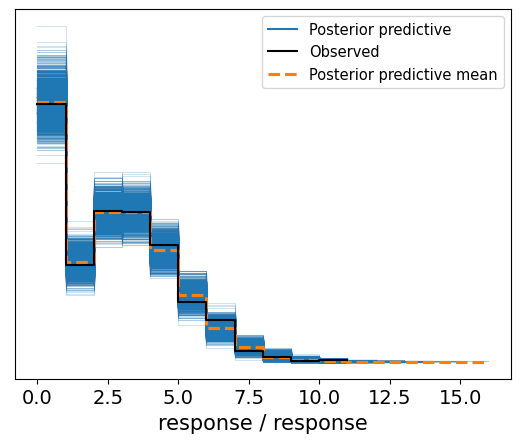

In [ ]:
az.plot_ppc(idata);

---

# Documentation notes

## Names

The logic is `{parent}_{child}`. The exception is the linear predictor of the main parameter, which is only `{child}`.

```python
bmb.Formula(
    "y ~ 1 + x + z",
    "sigma ~ 1 + x"
)
```

* `Intercept`
* `x`
* `z`
* `y_sigma`, the sigma parameter in the normal likelihood
* `sigma_Intercept`
* `sigma_x`

### Potential improvements

What about using just `sigma` instead of `{response_name}_sigma`. The gain: cleaner names. The downside: This pattern could be a conflict in a small number of cases where the name of predictors match the name of parameters in the likelihood. It could be "fixed" easily, by double checking the names of the predictors before creating the model.

If we want to create markdown to later be used as source of quarto documents...

* https://stackoverflow.com/questions/36237477/python-docstrings-to-github-readme-md
* https://pypi.org/project/pydoc-markdown/

Migration guide... 

* What used to be `model.terms["name"]` is now `model.response_component.terms["name"]`.
* Correlated priors for group-specific terms are not supported anymore. They will be brought back in the future.

To Do

* `plot_cap()` works only for the mean now, it should work for all the parameters, and even with posterior predictive draws.